In [116]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from __future__ import print_function, division # bring the print function and division of Python3 to 2.7

In [117]:
plt.style.use('seaborn-poster')

In [118]:
def exp_decay(x, A, t, y0):
    return A * np.exp(-x / t) + y0

def gauss(x, mu, sigma, N):
    return N / np.sqrt(2*np.pi)/sigma * np.exp(-0.5*(x - mu)**2/sigma**2)


## Ajustament d'une exponential

On va utilizer le metode de hit and miss pour generer une distribution de données exponential 


Parameters pour l'exponnential

In [119]:
t = 200.
A = 1/t 
y0 = 0.
xmax = 1200


In [120]:
mc_events = 10000

In [121]:
rnd1 = np.random.rand(mc_events)
rnd2 = np.random.rand(mc_events)
y = A*rnd1
x = xmax*rnd2
yprime = exp_decay(x, A, t, y0)

data = x[np.where(y < yprime)]

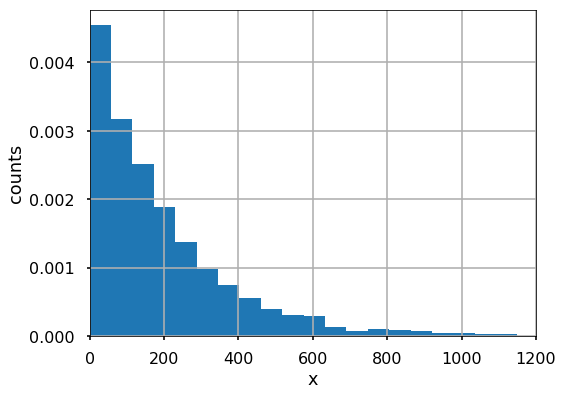

In [122]:
fig, ax = plt.subplots(figsize=(8,6))
plt.grid()
hist, binsedges, patches = ax.hist(data,bins = 20, normed=True)
ax.set_xlabel("x")
ax.set_ylabel("counts")
ax.set_xlim(0,1200)
plt.show()

### Minimitation avec le méthode des moindres carrés

On fait la minimitation  pas avec les données directament, mais avec les donnés déjà dans l'histogram, cad, avec le *binned data*. On va comparer le contenue des bins avec la prediction de notre modele.

In [123]:
binscenters = binsedges[:-1] + np.diff(binsedges)/2.

tmin = 100.
tmax = 300.

Q = []

tt = np.arange(tmin, tmax, 1.)

for tau in tt:
    Q.append(
        np.sum((hist - exp_decay(binscenters,1/tau, tau, y0))**2/hist)) 
        
tbest = tt[np.where(Q == np.min(Q))]

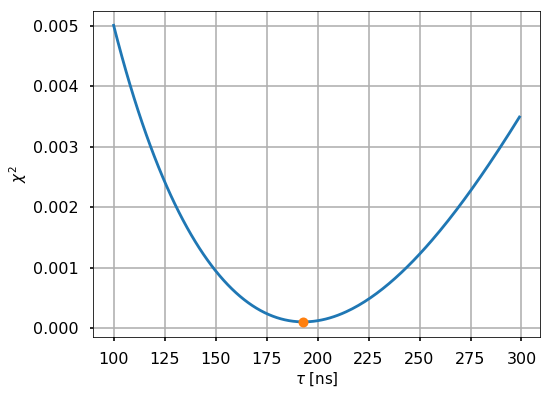

In [124]:
fig3, ax3 = plt.subplots(figsize=(8,6))
plt.grid()
ax3.plot(tt, Q)
ax3.set_xlabel(r"$\tau$ [ns]", fontsize=15)
ax3.set_ylabel("$\chi^2$", fontsize=15)
ax3.plot(tbest, np.min(Q),'o', ms=10)
plt.show()

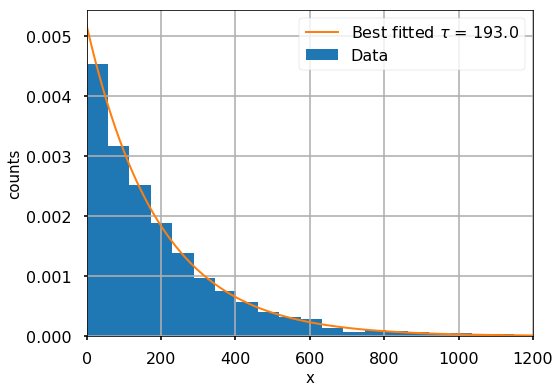

In [125]:
fig2, ax2 = plt.subplots(figsize=(8,6))
plt.grid()
ax2.hist(data,bins = 20,normed=True, label="Data")
x = np.arange(0, xmax, 0.1)

# If the histogram is NOT normalized (normed = False) I need to rescale the PDF by the number of mc event and the binwidth
#  binwidth = np.diff(bins)[0]
#  ax4.plot(x, exp_decay(x, 1/tbest*len(data2)*binwidth, tbest, y0), lw =2 , label=r"Best fitted $\tau$ = %.1f"%tbest)

ax2.plot(x, exp_decay(x, 1/tbest, tbest, y0), lw =2 , label=r"Best fitted $\tau$ = %.1f"%tbest)

ax2.set_xlabel("x", fontsize=15)
ax2.set_ylabel("counts", fontsize=15)
ax2.set_xlim(0,1200)
ax2.legend()
plt.show()

### Ajustement d'une gaussiane

Maintenant, on va faire l'ajustement des parametres d'une gaussiane. Pour ça on va génerer une gaussiane avec le méthode de Hit & Miss avec les parametre suivant:

In [126]:
mu = 200
sigma = 50
N = 1.

xmin = mu - 5*sigma
xmax = mu + 5*sigma
mc_events = 1000000

Maintenant on va faire le méthode de Hit & Miss

In [127]:
rnd1 = np.random.rand(mc_events)
rnd2 = np.random.rand(mc_events)
y = N*rnd1
x = xmin + (xmax - xmin)*rnd2
yprime = gauss(x, mu, sigma, N)

data = x[np.where(y < yprime)]

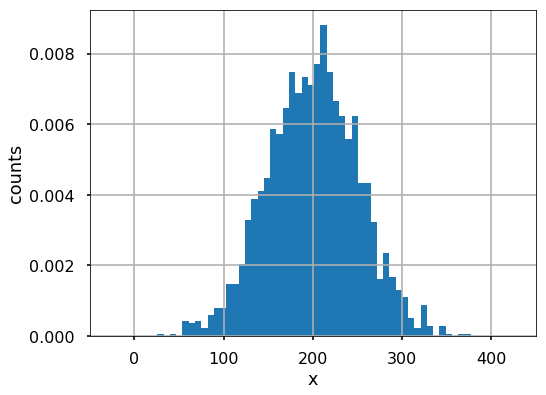

In [128]:
fig, ax = plt.subplots(figsize=(8,6))
plt.grid()
hist, binsedges, patches = ax.hist(data,bins = 50, normed=True)
ax.set_xlabel("x")
ax.set_ylabel("counts")
ax.set_xlim(xmin, xmax)
plt.show()

### Minimization using the Likelihood method

Here we are going to use the raw-data ie, we are not going to use the histogram but directly the array data

In [129]:
mumin = 195.
mumax = 205.
L = []

       
mm = np.arange(mumin, mumax, 0.01)

for m in mm:
    P = gauss(data, m, sigma, 1.)
    L.append(-np.sum(np.log(P)))
    
mubest = mm[np.where(L == np.min(L))]

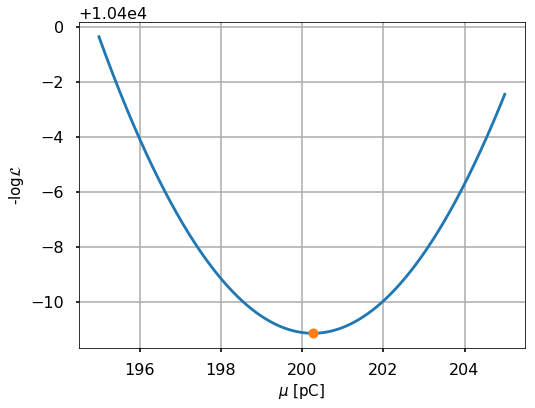

In [130]:
fig1, ax1 = plt.subplots(figsize=(8,6))
plt.grid()
ax1.plot(mm, L)
ax1.set_xlabel(r"$\mu$ [pC]", fontsize=15)
ax1.set_ylabel("-$\log \mathcal{L}$", fontsize=15)
ax1.plot(mubest, np.min(L),'o', ms=10)

plt.show()



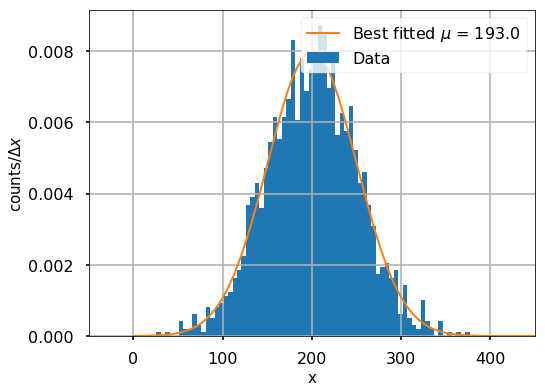

In [131]:
fig2, ax2 = plt.subplots(figsize=(8,6))
plt.grid()
ax2.hist(data,bins = 70,normed=True, label="Data")
x = np.arange(0, xmax, 0.1)

# If the histogram is NOT normalized (normed = False) I need to rescale the PDF by the number of mc event and the binwidth
#  binwidth = np.diff(bins)[0]
#  ax4.plot(x, exp_decay(x, 1/tbest*len(data2)*binwidth, tbest, y0), lw =2 , label=r"Best fitted $\tau$ = %.1f"%tbest)

ax2.plot(x, gauss(x, mubest, sigma, 1.), lw =2 , label=r"Best fitted $\mu$ = %.1f"%tbest)

ax2.set_xlabel("x", fontsize=15)
ax2.set_ylabel("counts/$\Delta x$", fontsize=15)
ax2.set_xlim(xmin, xmax)
ax2.legend(loc="upper right")
plt.show()

On peut aussi estimer l'erreur associé au valeur ajusté. Il faut simplement trouver quand le valuer minimal de $-\log\mathcal{L}$ change pour 1, 2, 3 unités... ça donnerá l'erreur à 1$\sigma$, 2$\sigma$ou 3$\sigma$.

[199.12 199.13 199.14 201.39 201.4  201.41]
[1.14 1.13 1.12 1.13 1.14 1.15]


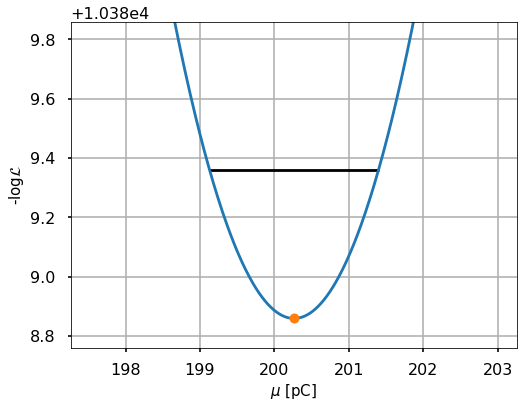

In [132]:
fig1, ax1 = plt.subplots(figsize=(8,6))
plt.grid()
ax1.plot(mm, L)
ax1.set_xlabel(r"$\mu$ [pC]", fontsize=15)
ax1.set_ylabel("-$\log \mathcal{L}$", fontsize=15)
ax1.plot(mubest, np.min(L),'o', ms=10)
musigmas = (mm[np.where(np.isclose(L, np.min(L) + 0.5,rtol=1e-6))])
print (musigmas)
ax1.hlines(y = np.min(L) + 0.5,xmin=musigmas[0], xmax=musigmas[-1])
sigmas = np.abs(musigmas - mubest)
print (sigmas)
ax1.set_ylim(np.min(L) - 0.1, np.min(L) + 1)
ax1.set_xlim(mubest - 3,mubest + 3)
plt.show()




L'erreur sour le valeur $\mu$ est un'estimation de combient le valuer estimé de $\mu$ peut changer si on repete plusier fois l'experience. Avec des méthodes de MonteCarlo est possible de repeter l'experience en generant plusier echantions des donnés. On va génerere 1000 fois une gaussiane, et ajuster 1000 fois cettes gaussiens!

In [133]:
mumin = 100.
mumax = 300.

mm = np.arange(mumin, mumax, 0.5)

mubests = []
#here we are going to use the Hit&Miss method 1000 times, and for each time we generate a sample of mc_events
for i in range(0, 1000):
    rnd1 = np.random.rand(mc_events)
    rnd2 = np.random.rand(mc_events)
    y = N*rnd1
    x = xmin + (xmax - xmin)*rnd2
    yprime = gauss(x, mu, sigma, N)

    data = x[np.where(y < yprime)]
    L = []
    for m in mm:
        P = gauss(data, m, sigma, 1.)
        L.append(-np.sum(np.log(P)))
        
    #For each fit of these 1000 gaussians, we take the best estimated mu value and put in a array    
    mubests.append(mm[np.where(L == np.min(L))])

mubests = np.array(mubests).flatten()

Maintenant on a 1000 estimations des $\mu$ pour 1000 gaussienes statisticament identiques. On peut voir que la distribution des $\mu$ a un ecart type que sera celui estime pour le méthode de vraissemblance.

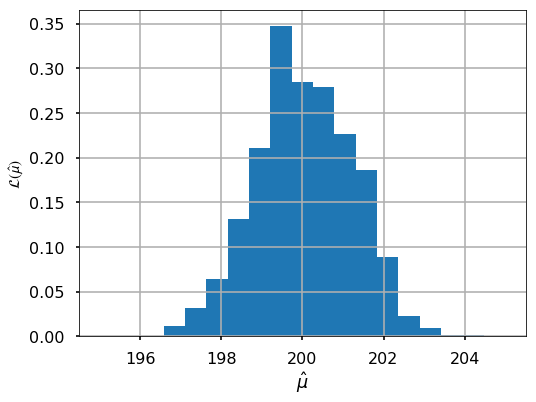

In [134]:
fig1, ax1 = plt.subplots(figsize=(8,6))
plt.grid()
ax1.hist(mubests, bins = np.linspace(195, 205, 20), normed=True)
ax1.set_ylabel("$\mathcal{L(\hat{\mu})}$", fontsize=15)
ax1.set_xlabel("$\hat{\mu}$")
plt.show()

### Ajustement des plusiers parametres

Pour l'instance on avait simplement ajusté un seul parametre $\mu$ en fixant l'écart type $\sigma$. Il es possible de faire l'ajustement pour le deux à la même fois. On doit simplement faire une scan pour le deux parametres.

In [135]:
# Make a grid scan of chi2 values:
mumin = 190.
mumax = 210.

sigma_min = 40.
sigma_max = 60
mu_grid    = np.arange(mumin, mumax, 0.1)
sigma_grid = np.arange(sigma_min, sigma_max, 0.1)

L = []
for m in mu_grid:
    L_m = []
    for s in sigma_grid:
        P = gauss(data, m, s, 1.)
        L_m.append(-np.sum(np.log(P)))
       
    L.append(L_m)
    
# a list of lists => a 2d array
L = np.array(L)

In [136]:
i_best = np.where(L == L.min())

print (i_best)

mu_best = mu_grid[i_best[0]]
sigma_best = sigma_grid[i_best[1]]

print (mu_best, sigma_best)

(array([100]), array([110]))
[200.] [51.]


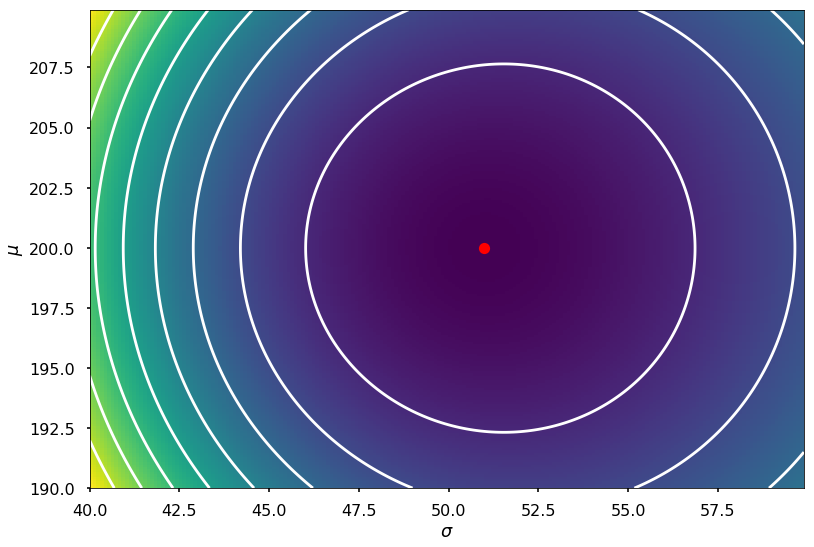

In [137]:
mesh = plt.pcolormesh(sigma_grid, mu_grid, L)

cs = plt.contour(sigma_grid, mu_grid, L, np.linspace(L.min(),L.max(),10),colors='white')

plt.plot(sigma_best, mu_best, marker='o',color='r')


plt.xlabel('$\sigma$')
plt.ylabel('$\mu$')
 